## Import libaries

In [11]:
import torch, torchvision
from torch import nn
from torch import optim
from torchvision.transforms import ToTensor
import torch.nn.functional as f
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import RandomCrop, RandomHorizontalFlip, RandomRotation
from mpl_toolkits.axes_grid1 import ImageGrid
import random

## Data loading, Preporcessing & Augmentation

In [2]:
# MNIST dataset

transform = transforms.Compose([
    RandomHorizontalFlip(),
    RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

mnist_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# Split dataset into train, validation, and test sets
train_size = 23040
val_size = 2000
test_size = len(mnist_dataset) - train_size - val_size

train_set, val_set, test_set = random_split(mnist_dataset, [train_size, val_size, test_size])
all_labels = torch.cat([train_set.dataset.targets, val_set.dataset.targets, test_set.dataset.targets])
# Data loaders
batch_size = 64

train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False, drop_last=True)

# Example usage
examples = iter(train_loader)
images, labels = next(examples)

## Visualiztion

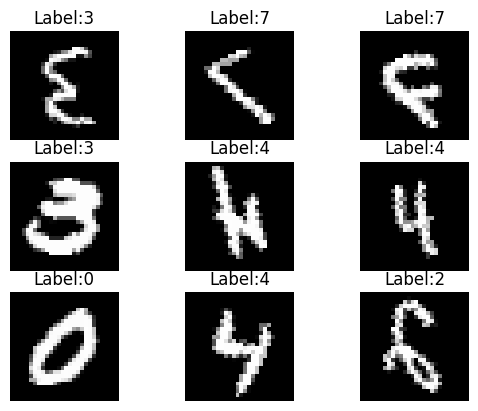

In [3]:
for n, (bild, label) in enumerate(zip(images[0:9], labels[0:9])):
  plt.subplot(3, 3, n + 1)
  plt.imshow(bild[0], cmap="gray")
  plt.axis("off")
  plt.title(f"Label:{labels[n].item()}")

## Model definition

In [4]:
import torch.nn as nn

class ClassifierCNNModel(nn.Module):
    def __init__(self, input_dim=(1, 28, 28), hidden_dim=32, n_classes=10, **kwargs):
        super(ClassifierCNNModel, self).__init__()
        (c, h, w) = input_dim
        self.model = nn.Sequential(
            self.create_conv_block(c, hidden_dim, complete_block=True),
            self.create_conv_block(hidden_dim, hidden_dim * 2, complete_block=True),
            nn.Flatten(),
            self.create_linear_block(int(h / 4) * int(w / 4) * hidden_dim * 2, n_classes, last_layer=True),
        )
        #self.dropout=nn.Dropout(dropout_prob)

    def create_conv_block(self, input_channels, output_channels, complete_block=True):
        if complete_block:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(),
                nn.MaxPool2d(2),
                #nn.Dropout(0.25)
            )

    def create_linear_block(self, input_channels, output_channels, last_layer=False):
        if last_layer:
            return nn.Sequential(
                nn.Linear(input_channels, output_channels),
                nn.LogSoftmax(dim=1)
            )
        else:
            return nn.Sequential(
                nn.Linear(input_channels, output_channels),
                nn.BatchNorm1d(output_channels),
                nn.ReLU(),
                self.dropout
            )

    def forward(self, image):
        return self.model(image)

## Hyperparameters setting and model running

In [5]:
# Hyperparameters
hparam = {
    "input_dim": (1, 28, 28),  # MNIST images are grayscale (1 channel) and 28x28 pixels
    "hidden_dim": 64,
    "n_classes": 10,  # MNIST dataset has 10 classes (digits 0 through 9)
    "lr": 0.01
}

model = ClassifierCNNModel(**hparam)
#model=CNN()
optimizer = torch.optim.Adam(model.parameters(), lr=hparam["lr"])

## Training & Evaluation

In [6]:
def train(epoch, model, train_loader, val_loader, optimizer,all_labels):
    x = torch.unique(all_labels, return_counts=True)[1]
    weight = torch.div(x.max().item(), x)
    model.train()
    train_total = 0
    train_correct = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(images)
        loss = torch.nn.functional.cross_entropy(output, labels, weight=weight)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(output.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    model.eval()
    eval_total = 0
    eval_correct = 0
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(val_loader):
            output = model(images)
            _, predicted = torch.max(output.data, 1)
            eval_total += labels.size(0)
            eval_correct += (predicted == labels).sum().item()

    train_accuracy = train_correct / train_total
    val_accuracy = eval_correct / len(val_loader.dataset)
    #return val_accuracy
    print("Epoch: {} Training accuracy: {:.2f} Validation accuracy: {:.2f}".format(epoch, train_accuracy, val_accuracy))

    # Save the model after training
    torch.save(model.state_dict(), 'trained_model.pth')

In [7]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Initialize an empty confusion matrix
num_classes = 10  # Assuming you have 10 classes for MNIST
conf_matrix = np.zeros((num_classes, num_classes))

for epoch in range(10):
    train(epoch, model, train_loader, val_loader,optimizer,all_labels)

model.eval()
total = 0
correct = 0
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update the confusion matrix
        conf_matrix += confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy(), labels=np.arange(num_classes))

# Compute test accuracy
test_accuracy = correct / total
print(f"Test accuracy: {test_accuracy:.2f}")

Epoch: 0 Training accuracy: 0.78 Validation accuracy: 0.89
Epoch: 1 Training accuracy: 0.90 Validation accuracy: 0.92
Epoch: 2 Training accuracy: 0.93 Validation accuracy: 0.92
Epoch: 3 Training accuracy: 0.94 Validation accuracy: 0.93
Epoch: 4 Training accuracy: 0.94 Validation accuracy: 0.94
Epoch: 5 Training accuracy: 0.94 Validation accuracy: 0.95
Epoch: 6 Training accuracy: 0.95 Validation accuracy: 0.94
Epoch: 7 Training accuracy: 0.95 Validation accuracy: 0.94
Epoch: 8 Training accuracy: 0.95 Validation accuracy: 0.95
Epoch: 9 Training accuracy: 0.95 Validation accuracy: 0.94
Test accuracy: 0.95


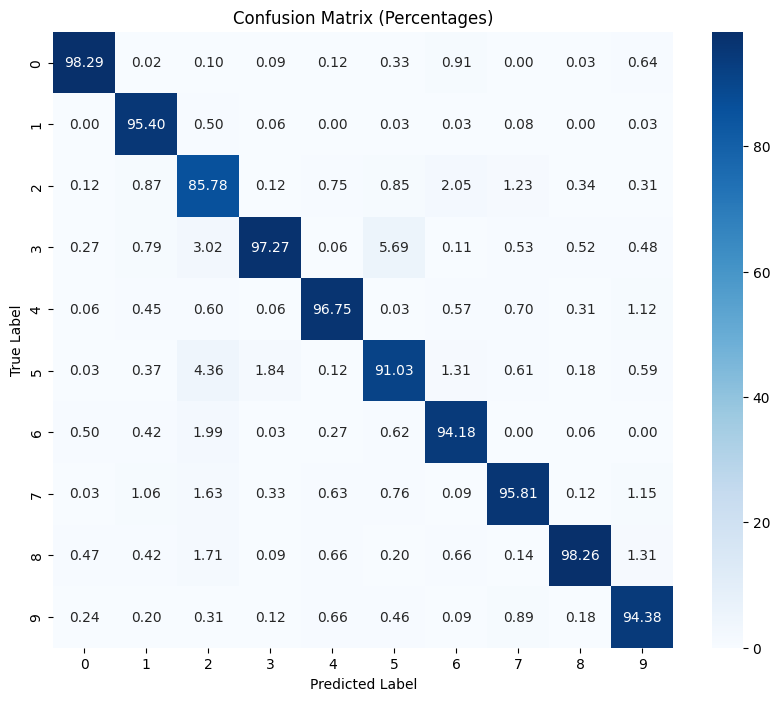

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate column-wise sums (predicted counts for each predicted label)
col_sums = np.sum(conf_matrix, axis=0)

# Normalize the confusion matrix to get percentages, handling division by zero
conf_matrix_percent = np.zeros_like(conf_matrix, dtype=float)
for i in range(len(col_sums)):
    if col_sums[i] != 0:
        conf_matrix_percent[:, i] = (conf_matrix[:, i] / col_sums[i]) * 100

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Percentages)')
plt.show()

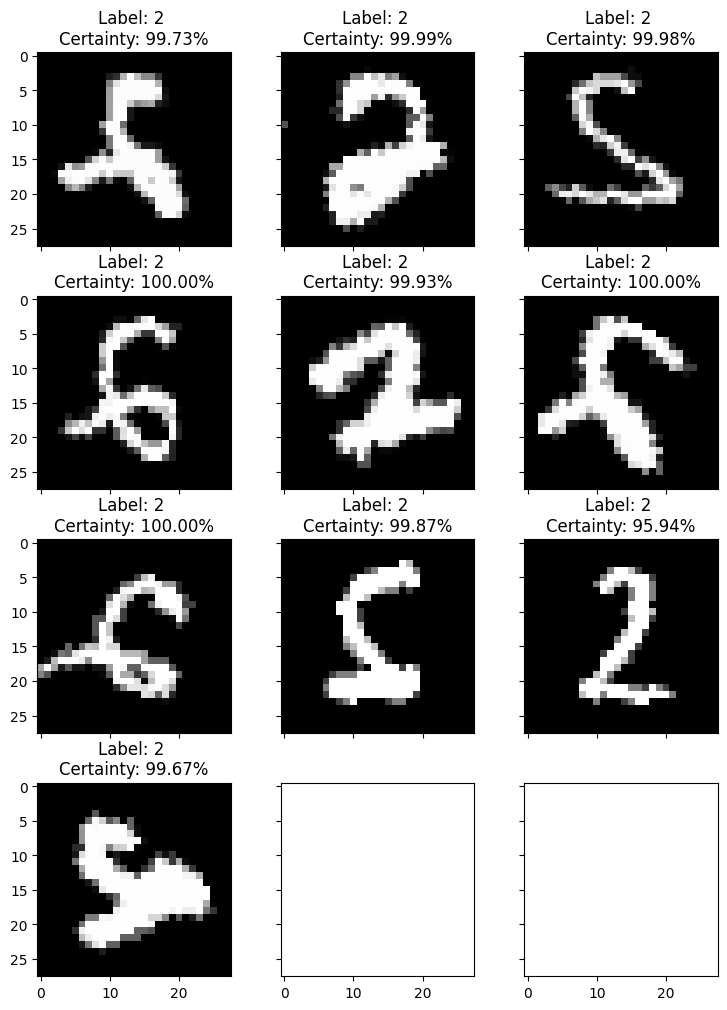

In [12]:
def plot_predictions(model, images, output_probs=False, adversarial=False):
    model.eval()
    with torch.no_grad():
        output = model(images)
        prob = f.softmax(output, dim=1)

        pred_list = torch.argmax(output, dim=1)
        pct_list = torch.max(prob, dim=1).values * 100

        # Setup image grid
        import math
        cols = 3
        rows = math.ceil(images.shape[0] / cols)
        fig = plt.figure(1, (12., 12.))
        grid = ImageGrid(fig, 111,  # similar to subplot(111)
                         nrows_ncols=(rows, cols),  # creates grid of axes
                         axes_pad=0.5,  # pad between axes in inch.
                         )

        # Get images and populate grid
        for i in range(len(prob)):
            image = images[i].squeeze().cpu().numpy()
            ax = grid[i]
            ax.imshow(image, cmap='gray')
            ax.set_title('Label: {0} \nCertainty: {1:.2f}%'.format(pred_list[i], pct_list[i]))
            ax.set_aspect('auto')  # Set aspect ratio to 'auto' to prevent distortion

            # Only use when plotting original, partial deriv, and adversarial images
            #if adversarial and (i % 3 == 1):
            #    ax.set_title("Adversarial \nPartial Derivatives")

        plt.show()

        return prob.cpu().numpy() if output_probs else None

# Get indices of images of digit 2 from the test dataset
indices_of_2s = torch.where(test_set.dataset.targets == 2)[0]

# Randomly select 10 indices (if there are more than 10 images)
random_indices = random.sample(indices_of_2s.tolist(), min(10, len(indices_of_2s)))

# Get 10 images of digit 2 from the test set
subset_images = torch.stack([test_set.dataset[i][0] for i in random_indices])
subset_labels = torch.tensor([test_set.dataset[i][1] for i in random_indices])

# Plot predictions for the subset of 10 images
plot_predictions(model, subset_images)

## Adversarial images

In [17]:
# Function to create and plot adversarial images
def create_adversarial_images(model, images, target_labels, lr=0.1, n_steps=1, output_probs=False):
    original_images = images.clone().detach()
    images.requires_grad = True

    probs_per_step = []

    for _ in range(n_steps):
        outputs = model(images)
        loss = f.cross_entropy(outputs, target_labels)
        loss.backward()

        with torch.no_grad():
            images -= lr * images.grad.sign()
            images.grad.zero_()

        probs = f.softmax(outputs.detach(), dim=1)
        probs_per_step.append(probs.cpu().numpy()) if output_probs else None

    adversarial_images = images.cpu().detach()

    return adversarial_images, probs_per_step

subset_images = torch.stack([test_set.dataset[i][0] for i in random_indices])

target_labels_6 = torch.zeros(10, 10)  # 10 images, 10 classes
target_labels_6[:, 6] = 1  # Set the index corresponding to class 6 to 1

In [20]:
adversarial_images, _ = create_adversarial_images(model, subset_images, target_labels_6, lr=0.1, n_steps=5)

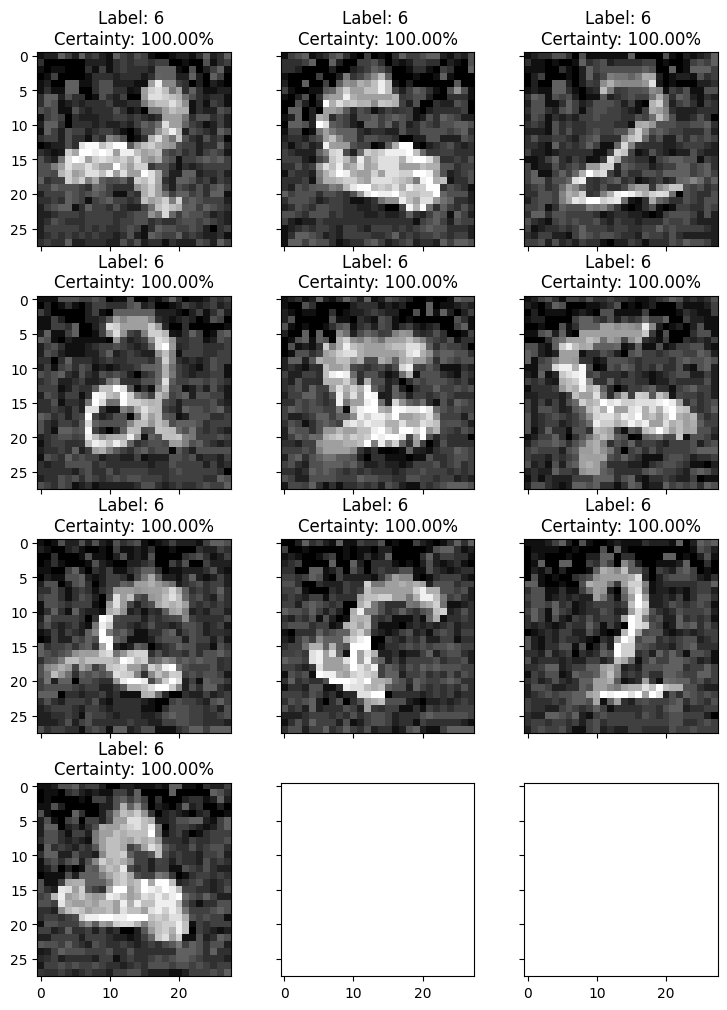

In [21]:
# Plot the adversarial images
plot_predictions(model, adversarial_images)

# Conclusions task 2.4

### A CNN model was trained on the MNIST dataset where an accuracy of 95% on the test dataset was achieved. Further adversarial images were created to cause missclassification by the trained model. This raises some thoughts regarding how a model can be "easily" be "manipulated". This could for instance be a concern when implementing Deep learning models in Healthcare to diagnose patients.